# Search and capture faces

In [146]:
# import the necessary packages
from requests import exceptions
import argparse
import requests
import cv2
import os
from skimage import io
import imutils
import face_recognition

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import json

In [227]:
# input data
#query = "안유진" #安宥真
#query = "최예나" #崔藝娜
#query = "Huh Yoon Jin produce" #李佳恩
#query = "허윤진 produce" #許允真
query = "Takahashi Juri" #高橋朱里
output = "output/"
detection_method = "hog"

In [228]:
# initialize
API_KEY = "df2d7bbb6fa646d2974a75c06d432372"
URL = "https://api.cognitive.microsoft.com/bing/v7.0/images/search"
MAX_RESULTS = 20
GROUP_SIZE = 50
OFFSET = 0
margin = 50

# when attemping to download images from the web both the Python
# programming language and the requests library have a number of
# exceptions that can be thrown so let's build a list of them now
# so we can filter on them
EXCEPTIONS = set([IOError, FileNotFoundError,
	exceptions.RequestException, exceptions.HTTPError,
	exceptions.ConnectionError, exceptions.Timeout])

In [229]:
# Search
# store the search term in a convenience variable then set the
# headers and search parameters
term = query
headers = {"Ocp-Apim-Subscription-Key" : API_KEY}
params = {"q": term, "offset": OFFSET, "count": GROUP_SIZE}

# make the search
print("[INFO] searching Bing API for '{}'".format(term))
search = requests.get(URL, headers=headers, params=params)
search.raise_for_status()

# grab the results from the search, including the total number of
# estimated results returned by the Bing API
results = search.json()
estNumResults = min(results["totalEstimatedMatches"], MAX_RESULTS)
print("[INFO] {} total results for '{}'".format(estNumResults,
	term))

[INFO] searching Bing API for 'Takahashi Juri'
[INFO] 20 total results for 'Takahashi Juri'


In [230]:
# Download Images
# loop over the estimated number of results in `GROUP_SIZE` groups
images = []
for offset in range(0, estNumResults, GROUP_SIZE):
    # update the search parameters using the current offset, then
    # make the request to fetch the results
    params["offset"] = offset
    search = requests.get(URL, headers=headers, params=params)
    search.raise_for_status()
    results = search.json()
    
    # loop over the results
    for v in results["value"]:
        # try to download the image
        try:
            # make a request to download the image
#             print(v["contentUrl"])
            img = io.imread(v["contentUrl"])
            images.append(img)
            
        # catch any errors that would not unable us to download the
        # image
        except Exception as e:
            # check to see if our exception is in our list of
            # exceptions to check for
            if type(e) in EXCEPTIONS:
                print("[INFO] skipping: {}".format(v["contentUrl"]))
                continue
                    
print("Total ≈≈: %d" % len(images))

Total ≈≈: 48


In [231]:
# loop over downloaded images and corp face
faces = []
for i, img in enumerate(images):
    if (img.shape[2] == 3):
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        rgb = imutils.resize(img, width=750)
        r = img.shape[1] / float(rgb.shape[1])
        boxes = face_recognition.face_locations(rgb,
            model=detection_method)

        # loop over the recognized faces
        for (top, right, bottom, left) in boxes:
            # rescale the face coordinates
            top = int(top * r - margin * r)
            right = int(right * r  + margin * r)
            bottom = int(bottom * r + margin * r)
            left = int(left * r - margin * r)
                        
            top = top if top > 0 else 0
            left = left if left > 0 else 0
            bottom = bottom if bottom < rgb.shape[0] else rgb.shape[0]
            right = right if right < rgb.shape[1] else rgb.shape[1]

            crop = img[top:bottom, left:right]
            if crop.shape[0] > 0 and crop.shape[1] > 0:
                scale = 150 / max(crop.shape)
                crop = cv2.resize(crop, (0,0), fx=scale, fy=scale)
#                 print(crop.shape)
                faces.append(crop)
            
print("Total corped faces:", len(faces))


Total corped faces: 45


IndexError: list index out of range

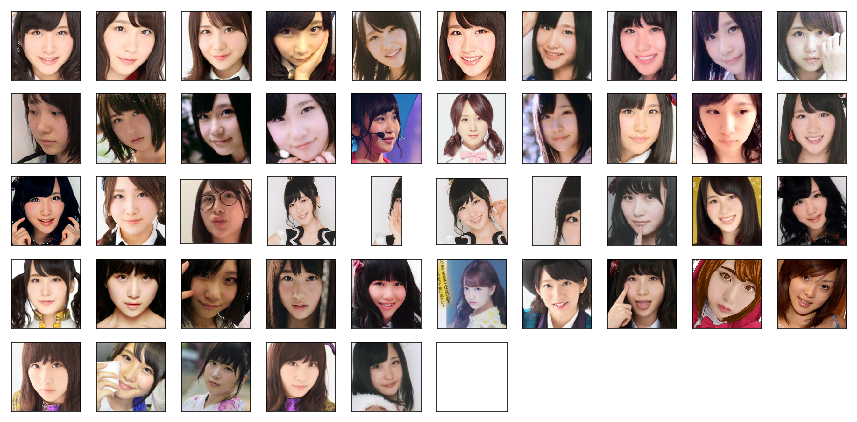

In [232]:
# show result
plt.figure(figsize=(15,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(faces[i], cmap=plt.cm.binary)

In [233]:
# Save faces to file
for i, face in enumerate(faces):
    cv2.imwrite('%s%d.jpg'% (output,i), 
            cv2.cvtColor(face, cv2.COLOR_BGR2RGB))